# Site Selection

This notebook will demonstrate, using data from the GRDC, the potential power value of installing a pico-scale hydropower device at a number of locations.

1. Import the data for 3 regions: this will be 3 river basins (in South America, Africa and Asia) with 5 rivers in each.
2. At each location calculate the river velocity over the course of a year.
3. Calculate the potential power output of a pico-scale hydropower device at each location for a year.
4. Plot the power output at each location. Plotting each river basin separately, with the rivers in each basin plotted on the same graph.

In [172]:
# build a dictionary of sites and their corresponding widths

# south america
rivers_sa = {
    # '4772140_Q_Day.Cmd.txt': 30, # duplicate
    '4772150_Q_Day.Cmd.txt': 30,
    '4772300_Q_Day.Cmd.txt': 100,
    '4773050_Q_Day.Cmd.txt': 45,
    '4773800_Q_Day.Cmd.txt': 150,
}

# west africa
rivers_wa = {
    '1216300_Q_Day.Cmd.txt': 55,
    '1216400_Q_Day.Cmd.txt': 35,
    '1219500_Q_Day.Cmd.txt': 120,
    '1321880_Q_Day.Cmd.txt': 25,
    '1322880_Q_Day.Cmd.txt': 80,
    '1324580_Q_Day.Cmd.txt': 60,
}

# east asia
rivers_ea = {
    # '2260100_Q_Day.Cmd.txt': 200, # too fast
    '2260400_Q_Day.Cmd.txt': 500,
    '2646200_Q_Day.Cmd.txt': 1300,
    '2651080_Q_Day.Cmd.txt': 450,
    '2651100_Q_Day.Cmd.txt': 4300,
}

data_array = [rivers_sa, rivers_wa, rivers_ea]

In [55]:
# imports
from mech_module import *
from arima_functions import *
from scipy.interpolate import UnivariateSpline as spline


Unable to normalize json: "Key 'results' not found. If specifying a record_path, all elements of data should have the path." Likely too many requests. Sleeping for 1 second and trying again.
Unable to normalize json: "Key 'results' not found. If specifying a record_path, all elements of data should have the path." Likely too many requests. Sleeping for 1 second and trying again.
Unable to normalize json: "Key 'results' not found. If specifying a record_path, all elements of data should have the path." Likely too many requests. Sleeping for 1 second and trying again.
Unable to normalize json: "Key 'results' not found. If specifying a record_path, all elements of data should have the path." Likely too many requests. Sleeping for 1 second and trying again.


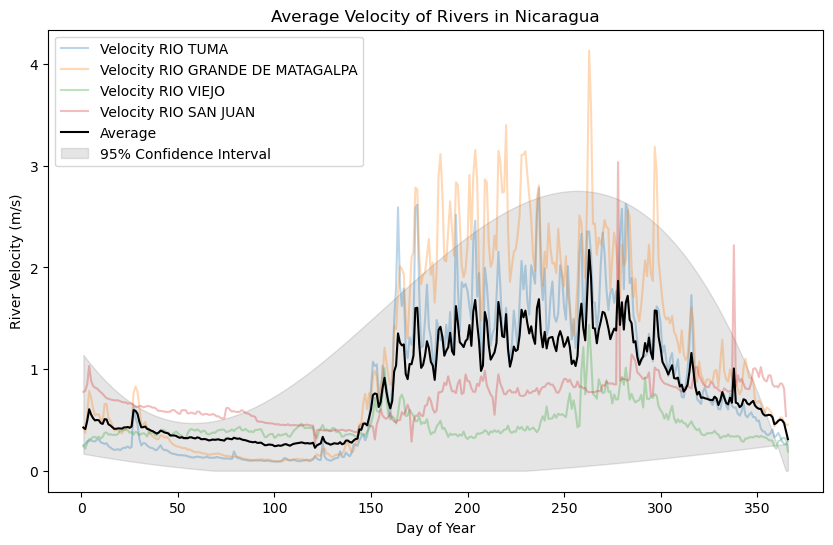

Unable to normalize json: "Key 'results' not found. If specifying a record_path, all elements of data should have the path." Likely too many requests. Sleeping for 1 second and trying again.
Unable to normalize json: "Key 'results' not found. If specifying a record_path, all elements of data should have the path." Likely too many requests. Sleeping for 1 second and trying again.
Unable to normalize json: "Key 'results' not found. If specifying a record_path, all elements of data should have the path." Likely too many requests. Sleeping for 1 second and trying again.
Unable to normalize json: "Key 'results' not found. If specifying a record_path, all elements of data should have the path." Likely too many requests. Sleeping for 1 second and trying again.
Unable to normalize json: "Key 'results' not found. If specifying a record_path, all elements of data should have the path." Likely too many requests. Sleeping for 1 second and trying again.


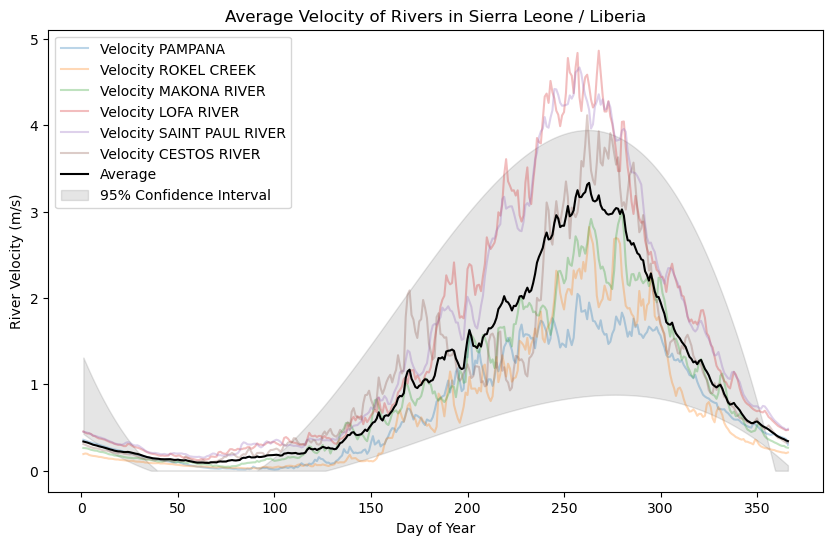

Unable to normalize json: "Key 'results' not found. If specifying a record_path, all elements of data should have the path." Likely too many requests. Sleeping for 1 second and trying again.
Unable to normalize json: "Key 'results' not found. If specifying a record_path, all elements of data should have the path." Likely too many requests. Sleeping for 1 second and trying again.


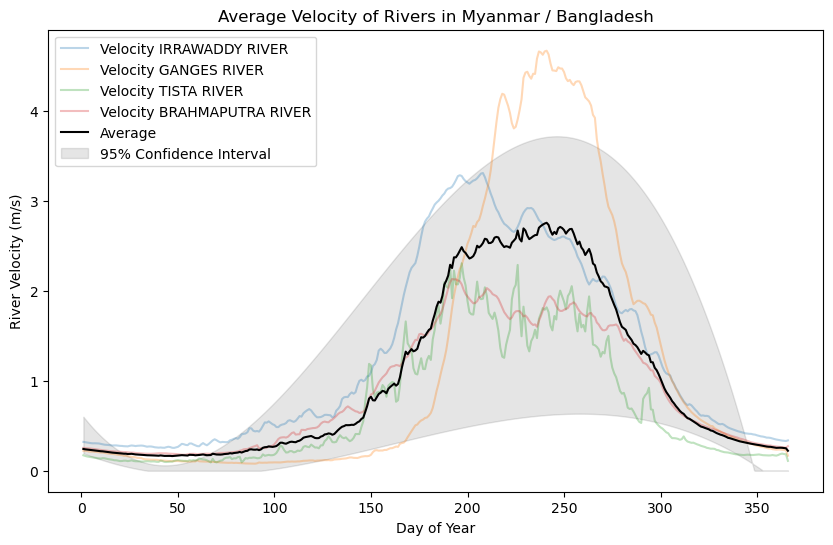

In [179]:
# using data from the ....
for continent, rivers in zip(['Nicaragua', 'Sierra Leone / Liberia', 'Myanmar / Bangladesh'], data_array):

    # empty df for south america
    df = pd.DataFrame()
    # add date column empty

    for river,width in rivers.items():
        metadata, data = read_data('site_data/' + river)
        station_info, parsed_data = process_data(metadata, data)
        # take the first 2 years of data
        # parsed_data = parsed_data[:730]
        # calculate slope to use to calc velocity
        lat1 = station_info['Latitude (DD)']
        long1 = station_info['Longitude (DD)']
        S = calc_slope(lat1, long1, 0.001)
        Q = parsed_data['Value'].mean() # average discharge m^3/s
        W = width # width in meters
        D = (Q / (W**1.02 * S**0.35))**(1/1.74) # depth in meters
        parsed_data['Velocity ' + station_info['River']] = parsed_data['Value'] / (W * D) # velocity in m/s
        # drop the 'value' column
        parsed_data = parsed_data.drop(columns='Value')
        
        # concatenate the data on the 'Date' column
        if df.empty:
            df = parsed_data
        else:
            df = pd.merge(df, parsed_data, on='Date', how='outer')

    # make date the index
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index('Date')

    df_avg = df.groupby(df.index.dayofyear).mean()
    # make an overall average
    df_avg['Average'] = df_avg.mean(axis=1)

    plt.figure(figsize=(10,6))
    # plot the individual columns as a confidence interval
    for column in df_avg.columns[:-1]:
        plt.plot(df_avg.index, df_avg[column], label=column, alpha=0.3)

    plt.plot(df_avg.index, df_avg['Average'], label='Average', color='black', linestyle='-')
    # plot the 95% confidence interval as a solid fill with more resolution by interpolating the data
    x = df_avg.index
    y_avg = df_avg['Average']
    y_std = df_avg.std(axis=1)
    n = len(x)

    # Calculate the standard error
    se = y_std 

    # Calculate the upper and lower bounds of the confidence interval
    y1 = y_avg + se * 1.96
    y2 = y_avg - se * 1.96

    # Create the spline functions
    spl = spline(x, y1, k=3)
    spl2 = spline(x, y2, k=3)

    x2 = np.linspace(x.min(), x.max(), 1000)
    y3 = spl(x2)
    y4 = spl2(x2)

    y3 = np.maximum(y3, 0)
    y4 = np.maximum(y4, 0)

    plt.fill_between(x2, y3, y4, color='k', alpha=0.1, label='95% Confidence Interval')

    plt.title('Average Velocity of Rivers in ' + continent)
    plt.ylabel('River Velocity (m/s)')
    plt.xlabel('Day of Year')
    plt.legend()
    plt.show()

